In [202]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# import plotly.express as px

import statsmodels.api as sm

from IPython.display import display

## Limpeza dos dados

In [203]:
df0 = pd.read_csv('sao-paulo-properties-april-2019.csv')
display(df0.head(3))
display(df0.shape)

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.542818,-46.485665


(13640, 16)

`conferimos se há valor nulo (nan) no dataframe`

In [204]:
display(df0.isnull().sum())

Price               0
Condo               0
Size                0
Rooms               0
Toilets             0
Suites              0
Parking             0
Elevator            0
Furnished           0
Swimming Pool       0
New                 0
District            0
Negotiation Type    0
Property Type       0
Latitude            0
Longitude           0
dtype: int64

In [205]:
display(df0.dtypes)

Price                 int64
Condo                 int64
Size                  int64
Rooms                 int64
Toilets               int64
Suites                int64
Parking               int64
Elevator              int64
Furnished             int64
Swimming Pool         int64
New                   int64
District             object
Negotiation Type     object
Property Type        object
Latitude            float64
Longitude           float64
dtype: object

`Analisamos quias series tinham valores binários que deveriamos substituir por 'sim' ou 'não', ou valores irrelevantes para a análise por terem valor constante. Assim por uma questão de visivelmente não ser o caso das series ['Price', 'Condo', 'Size', 'District', 'Latitude','Longitude'] já as excluímos dessa análise`

In [206]:
display(df0['Rooms'].unique())
display(df0['Toilets'].unique())
display(df0['Suites'].unique())
display(df0['Parking'].unique())
display(df0['Elevator'].unique())
display(df0['Furnished'].unique())
display(df0['Swimming Pool'].unique())
display(df0['New'].unique())
display(df0['Negotiation Type'].unique())
display(df0['Property Type'].unique())


array([ 2,  1,  3,  4,  5, 10,  6,  7], dtype=int64)

array([2, 3, 4, 1, 5, 6, 7, 8], dtype=int64)

array([1, 3, 2, 4, 0, 5, 6], dtype=int64)

array([1, 2, 3, 4, 5, 6, 8, 9, 0, 7], dtype=int64)

array([0, 1], dtype=int64)

array([0, 1], dtype=int64)

array([0, 1], dtype=int64)

array([0, 1], dtype=int64)

array(['rent', 'sale'], dtype=object)

array(['apartment'], dtype=object)

`Concluímos que as séries ['Elevator, Furnished, Swimming Pool, New'] podem ser transformadas
em categorias. Além disso, consideramos que as séries ['Latitude, Longitude'] podem ser desconsideradas na análise de preços pois a série ['District'] já permite analisar a interferência da região no preço. Ademais, a série ['Property Type'] tem todos os valores iguais e por isso pode ser descartado.`

`Verificamos que 52,99 % dos nossos dados eram sobre apartamentos sendo alugados, 47,01 % sobre apartamentos sendo vendidos. Por isso decidimos trabalhar na previsão dos preços de alugueis.`

rent: 52.99 %
sale: 47.01 %


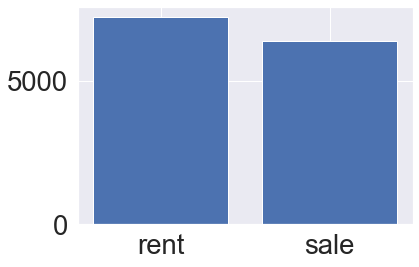

In [207]:
l_values = df0['Negotiation Type'].value_counts()

print(f'rent: {l_values[0]/df0.shape[0]*100:.2f} %')
print(f'sale: {l_values[1]/df0.shape[0]*100:.2f} %')
plt.bar(df0['Negotiation Type'].unique(), l_values)
plt.show()

# optamos por analizar somente os preços dos aps. alugados pois avisa uma base de dados
# um pouco maior

`Retiramos as séries consideradas descartáveis e filtramos apenas as linhas selencionando apenas as que tinham apartamentos sendo alugados.`

In [208]:
rent = df0['Negotiation Type'] == 'rent'
df = df0.loc[rent,['Price', 'Condo', 'Size', 'Rooms', 'Toilets', 'Suites', 'Parking', 'Elevator', 'Furnished', 'Swimming Pool', 'New', 'District']]

# df para regressão linear
df_rl = df.drop(columns='District', axis=1)

`Transformamos as séries binárias e a séries não numéricas em categorias e substituímos os valores 0 e 1 por não e sim respectivamente.`

In [209]:
df['District'] = df['District'].astype('category')

df['Swimming Pool'] = df['Swimming Pool'].astype('category')
df['New'] = df['New'].astype('category')
df['Furnished'] = df['Furnished'].astype('category')
df['Elevator'] = df['Elevator'].astype('category')

In [210]:
df['Swimming Pool'].cat.categories = ['No', 'Yes']
df['Furnished'].cat.categories = ['No', 'Yes']
df['Elevator'].cat.categories = ['No', 'Yes']
df['New'].cat.categories = ['No', 'Yes']
df['Swimming Pool'].cat.categories = ['No', 'Yes']

df

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District
0,930,220,47,2,2,1,1,No,No,No,No,Artur Alvim/São Paulo
1,1000,148,45,2,2,1,1,No,No,No,No,Artur Alvim/São Paulo
2,1000,100,48,2,2,1,1,No,No,No,No,Artur Alvim/São Paulo
3,1000,200,48,2,2,1,1,No,No,No,No,Artur Alvim/São Paulo
4,1300,410,55,2,2,1,1,Yes,No,No,No,Artur Alvim/São Paulo
...,...,...,...,...,...,...,...,...,...,...,...,...
11205,3700,595,73,1,2,1,1,No,No,Yes,No,Brooklin/São Paulo
11206,21000,3000,208,4,4,3,3,Yes,Yes,Yes,No,Brooklin/São Paulo
11207,3800,710,55,1,1,0,1,No,Yes,Yes,No,Brooklin/São Paulo
11208,5000,2354,205,3,2,1,2,Yes,No,No,No,Brooklin/São Paulo


`confirmamos que todos os dados são da cidade de São Paulo`

In [211]:
df[['District','City']] = df['District'].str.split('/', expand = True)
display(df.City.unique())

array(['São Paulo'], dtype=object)

`Limpamos a série ['District'], retirando a informação de que os bairros são da cidade de São Paulo.`

In [212]:
df = df.drop(columns='City', axis=1)
df['District'] = df['District'].astype('category')

In [213]:
display(df.sort_values(by='Price').head())
display(df.shape)
display(df.dtypes)

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District
508,480,295,48,2,2,1,1,No,No,No,No,São Rafael
4486,500,380,66,2,1,0,1,No,No,No,No,Jaraguá
2878,500,36,45,1,2,1,0,No,No,Yes,No,Vila Maria
288,500,0,40,1,2,1,1,No,No,No,No,Jardim Helena
122,500,0,50,1,2,1,1,No,No,No,No,Cidade Líder


(7228, 12)

Price               int64
Condo               int64
Size                int64
Rooms               int64
Toilets             int64
Suites              int64
Parking             int64
Elevator         category
Furnished        category
Swimming Pool    category
New              category
District         category
dtype: object

## Análize dos dados

In [214]:
# df2 = df.loc[:, ['Price', 'New']]

# px.histogram(df2, x='Price', color='New') # opacity=0.5,

In [215]:
# df2 = df.loc[:, ['Price', 'Swimming Pool']]

# px.histogram(df2, x='Price', color='Swimming Pool') # opacity=0.5,

In [216]:
# df2 = df.loc[:, ['Price', 'Furnished']]

# px.histogram(df2, x='Price', color='Furnished') # opacity=0.5,

In [217]:
# df2 = df.loc[:, ['Price', 'Elevator']]

# px.histogram(df2, x='Price', color='Elevator') # opacity=0.5,

In [218]:
# # ['Price', 'Condo', 'Size', 'Rooms', 'Toilets', 'Suites', 'Parking', 'Elevator', 'Furnished', 'Swimming Pool', 'District', 'Property Type']
# print(f'Correlação Price/Condo: {df.Price.corr(df.Condo)*100:.3f} %')
# print(f'Correlação Price/Size: {df.Price.corr(df.Size)*100:.3f} %')
# print(f'Correlação Price/Rooms: {df.Price.corr(df.Rooms)*100:.3f} %')
# print(f'Correlação Price/Toilets: {df.Price.corr(df.Toilets)*100:.3f} %')
# print(f'Correlação Price/Suites: {df.Price.corr(df.Suites)*100:.3f} %')
# print(f'Correlação Price/Parking: {df.Price.corr(df.Parking)*100:.3f} %')
# # print(f'Correlação Price\Elevator: {df.Price.corr(df.Elevator)*100:.3f} %')
# # print(f'Correlação Price\Furnished: {df.Price.corr(df.Furnished)*100:.3f} %')
# # # print(f'Correlação Price/Swimming Pool: {df['Price'].corr(df['Swimming Pool'])*100:.3f} %')
# # print(f'Correlação Price\District: {df.Price.corr(df.District)*100:.3f} %')
# # # print(f'Correlação Price/Property Type: {df.Price.corr(df.Property Type)*100:.3f} %')

In [219]:
# Price	Condo	Size	Rooms	Toilets	Suites

## test train

In [220]:
X_test = pd.read_csv('X_test.csv')
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

## Regressão Linear

In [221]:
def regress(Y, X):

    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    r = model.fit()
    
    return r

In [222]:
X_train['Swimming Pool'] = X_train['Swimming Pool'].astype('category')
X_train['New'] = X_train['New'].astype('category')
X_train['Furnished'] = X_train['Furnished'].astype('category')
X_train['Elevator'] = X_train['Elevator'].astype('category')

X_train['Swimming Pool'].cat.categories = ['0', '1']
X_train['Furnished'].cat.categories = ['0', '1']
X_train['Elevator'].cat.categories = ['0', '1']
X_train['New'].cat.categories = ['0', '1']

X_train['Swimming Pool'] = X_train['Swimming Pool'].astype('int64')
X_train['New'] = X_train['New'].astype('int64')
X_train['Furnished'] = X_train['Furnished'].astype('int64')
X_train['Elevator'] = X_train['Elevator'].astype('int64')

In [223]:
Y = y_train['Price']
X = X_train[['Condo', 'Size', 'Rooms', 'Toilets', 'Suites', 'Parking', 'Elevator', 'Furnished', 'Swimming Pool', 'New']]
results = regress(Y,X)
results.summary()
results.pvalues

const             8.906199e-01
Condo             2.192569e-43
Size             8.916965e-156
Rooms             3.086652e-50
Toilets           7.803119e-03
Suites            5.839098e-02
Parking           3.787347e-17
Elevator          1.529014e-01
Furnished         3.695950e-43
Swimming Pool     3.905467e-04
New               7.742408e-01
dtype: float64

In [224]:
X = X.drop(columns='New', axis=1)
results = regress(Y,X)
results.summary()
results.pvalues

const             8.868752e-01
Condo             2.083484e-43
Size             8.003297e-156
Rooms             3.155231e-50
Toilets           7.731382e-03
Suites            5.849949e-02
Parking           3.911884e-17
Elevator          1.485400e-01
Furnished         3.672589e-43
Swimming Pool     3.953153e-04
dtype: float64

In [225]:
X = X.drop(columns='Elevator', axis=1)
results = regress(Y,X)
results.summary()
results.pvalues

const             8.118957e-01
Condo             2.113042e-43
Size             1.083067e-156
Rooms             5.734968e-50
Toilets           1.310419e-02
Suites            4.972724e-02
Parking           1.765640e-17
Furnished         8.931940e-43
Swimming Pool     6.706024e-04
dtype: float64

In [226]:
X = X.drop(columns='Suites', axis=1)
results = regress(Y,X)
results.summary()
results.pvalues

const             1.198261e-01
Condo             7.684512e-43
Size             1.041524e-160
Rooms             1.941865e-50
Toilets           5.448455e-13
Parking           3.670623e-19
Furnished         5.786382e-43
Swimming Pool     5.006387e-04
dtype: float64

In [227]:
X = X.drop(columns='Swimming Pool', axis=1)
results = regress(Y,X)
results.pvalues

const         2.066134e-01
Condo         2.853670e-44
Size         2.524286e-158
Rooms         1.597524e-49
Toilets       2.181445e-14
Parking       1.109603e-22
Furnished     1.970909e-47
dtype: float64

In [228]:
X = X.drop(columns='Toilets', axis=1)
results = regress(Y,X)
results.pvalues

const         2.459250e-01
Condo         1.063377e-43
Size         5.283442e-188
Rooms         3.992929e-44
Parking       1.420912e-38
Furnished     2.293540e-51
dtype: float64

In [229]:
X = X.drop(columns='Parking', axis=1)
results = regress(Y,X)
results.pvalues

const         7.556512e-03
Condo         9.334929e-72
Size         4.566645e-239
Rooms         1.094247e-28
Furnished     2.282581e-58
dtype: float64

In [230]:
X = X.drop(columns='Rooms', axis=1)
results = regress(Y,X)
results.pvalues

const         3.452242e-28
Condo         1.420614e-78
Size         1.311498e-223
Furnished     1.088813e-67
dtype: float64

In [231]:
X = X.drop(columns='Furnished', axis=1)
results = regress(Y,X)
results.pvalues

const     1.328271e-10
Condo     8.931316e-97
Size     2.498904e-193
dtype: float64

In [232]:
X = X.drop(columns='Condo', axis=1)
results = regress(Y,X)
results.pvalues

const    1.158038e-19
Size     0.000000e+00
dtype: float64

In [238]:
# sm.graphics.plot_partregress('Price', 'Size', ['Furnished', 'Condo'], data=df, obs_labels=False)

### Referêcias

- Análise de dados e previsão de preços: https://www.kaggle.com/code/juxwzera/predictions-for-price
- Algumas funções do statsmodels.api: https://www.statsmodels.org/stable/gettingstarted.html